
# ORE Jupyter Dashboard

This is based on the sample from the ORE site, I removed the non-matplotlib charting, to keep the container simpler
There's a bit more simplification as well. Do take a look at the original https://github.com/OpenSourceRisk/Engine/blob/master/FrontEnd/Python/Visualization/npvcube/ore_jupyter_dashboard.ipynb


This dashboard contains examples to visualize an NPV cube generated by ORE.

## Launch ORE

In [1]:
# default paths (either change here or use the interface below)
ore_path = '/ore/App/ore'
ore_xml = './Input/ore.xml'

This launcher allows you to kick off a job in ORE. It will take time to finish.

In [2]:
from ipywidgets import Text, Button
from IPython.display import display
import subprocess
import os

cwd = os.getcwd() # save directory of the jupyter notebook
config_path = os.path.dirname(os.path.dirname(ore_xml))
os.chdir(config_path) # navigate to ore config folder
command = [ore_path, os.path.join(os.path.join(config_path, 'Input'),'ore.xml')]
print("Starting ORE run... please wait...")
p = subprocess.Popen(command,
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE)
stdout, stderr = p.communicate()
os.chdir(cwd) # go back to jupyter notebook
print("ORE run successful!")


Text(value='/ore/App/ore', description='ORE Path:')

Text(value='./Input/ore.xml', description='XML File:')

Button(description='Launch', style=ButtonStyle())

## Select Netting Sets and Trades

This section allows you to select the netting sets and trades you want to analyze. Select the cube file by either changing the default path in the cell below or by pasting its location in the menu after you executed the cells of this section. Click on `Load` to load in the data. You can select only one netting set at a time, but arbitrary few or many trades in it.

In [3]:
global npv_cube_filename
npv_cube_filename = os.path.join(os.getcwd(),'./Output/rawcube.csv')

In [4]:
import pandas as pd       
from ipywidgets import Select, SelectMultiple, HBox

current_netting_sets = [0]
def set_current_netting_sets(netting_sets):
    current_netting_sets = netting_sets['new']

current_trades = [0]
def set_current_trades(trades):
    current_trades = trades['new']

netting_set_selector = Select(description='Netting Sets:')
trades_selector = SelectMultiple(description='Trades:')
netting_set_selector.observe(set_current_netting_sets, names='value')
trades_selector.observe(set_current_trades, names='value')
def load_cube_file(b):
    csv_file = npv_file_selector.value
    global df
    df = pd.read_csv(csv_file)
    df.columns = ['Id', 'NettingSet', 'DateIndex' , 'Date', 'Sample', 'Depth', 'Value']
    netting_set_selector.options = list(df.NettingSet.unique())
    trades_selector.options = list(df.Id.unique())
    trades_selector.value = trades_selector.options


npv_file_selector = Text(description='Cube File:', value=npv_cube_filename, width=200)
read_npv_button = Button(description='Load')
read_npv_button.on_click(load_cube_file)

load_cube_file(read_npv_button)

display(HBox([npv_file_selector, read_npv_button]))
display(HBox([netting_set_selector, trades_selector]))

## Plot Exposure Density Surface (matplotlib)

We aggregate the npv values of the trades from the cube to a netting set level. For each date (x-axis) we estimate the density of the distribution of the values (y-axis) and plot the value of this density (z-axis) as a surface plot. Notice that the z-axis has no business meaning.

<IPython.core.display.Javascript object>


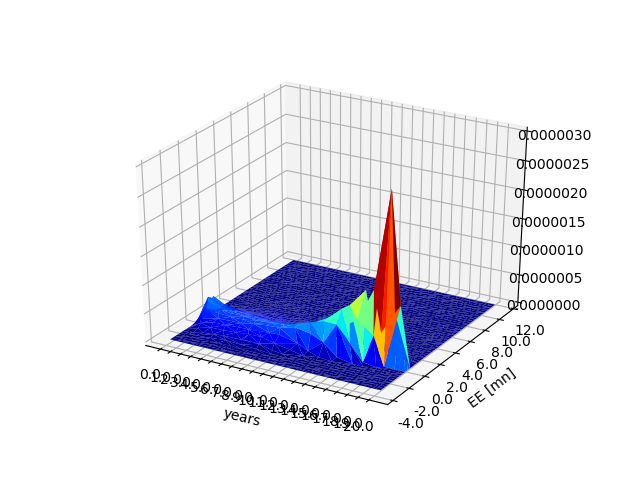

RadioButtons(description='Exposure Type:', options=('EE', 'EPE', 'ENE'), value='EE')

In [5]:
import numpy as np

from enum import Enum
from ipywidgets import RadioButtons, FloatSlider

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.font_manager import FontProperties

from scipy.stats.kde import gaussian_kde
from numpy.linalg.linalg import LinAlgError

class ExposureTypes(Enum):
    EE = 'EE'
    EPE = 'EPE'
    ENE = 'ENE'

# sum values over selected trades in netting set
df_surface_ee = df[(df.NettingSet == netting_set_selector.value) & df.Id.isin(trades_selector.value)][['Id', 'Value', 'Sample', 'DateIndex']].groupby(['DateIndex','Sample']).sum().reset_index()
# truncate for EPE or ENE
df_surface_epe = df_surface_ee.copy()
df_surface_epe.loc[df_surface_epe['Value']<0,'Value']=0
df_surface_ene = df_surface_ee.copy()
df_surface_ene.loc[df_surface_ene['Value']>0,'Value']=0
df_data = {ExposureTypes.EE:df_surface_ee,
          ExposureTypes.EPE:df_surface_epe,
          ExposureTypes.ENE:df_surface_ene,}

fig_surface = plt.figure()
fig_surface.canvas.set_window_title('Density Surface')

dates = pd.to_datetime(df['Date']).unique()
dates = dates - dates.min()
years = dates.astype('timedelta64[D]') / np.timedelta64(1, 'D') / 365

def plot_exposure_surface(current_exposure):
    global df_data
    df_surface = df_data[ExposureTypes[current_exposure]]
     # for each date index, calculate densities of distribution of values
    grid_size = 50
    global npv_min
    global npv_max
    npv_min = df_surface.Value.min()
    npv_max = df_surface.Value.max()
    global dist_space
    dist_space = np.linspace(npv_min, npv_max, grid_size)
    global num_dates
    num_dates = len(df_surface.DateIndex.unique())
    global density_values
    density_values = np.zeros((num_dates, grid_size))
    for k in range(num_dates):
        row = df_surface.loc[df_surface['DateIndex']==k, 'Value'].values
        try:
            density = gaussian_kde(row)
            density_values[k] = density(dist_space)
        except:
            density_values[k] = np.zeros(grid_size)
    global density_max
    density_max = np.max(density_values)
    
    # plot result
    global fig_surface
    fig_surface.clear()
    ax_surface = fig_surface.add_subplot(111, projection='3d')
    date_step=4
    ax_surface.set_xticks(years[::date_step])
    ax_surface.set_xticklabels(years[::date_step])
    ax_surface.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: "{:,.1f}".format(x)))
    ax_surface.set_xlabel('years')
    ax_surface.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: "{:,.1f}".format(x/1000000)))
    ax_surface.set_ylabel(exposure_selector.value+" [mn]")
    X, Y = np.meshgrid(years, dist_space)
    ax_surface.plot_trisurf(X.flatten(), Y.flatten(), density_values.T.flatten(), cmap=cm.jet, linewidth=0)
    plt.show()

def change_exposure_type(rb):
    plot_exposure_surface(rb['new'])

exposure_selector = RadioButtons(description='Exposure Type:', options=[name for name,member in ExposureTypes.__members__.items()])
exposure_selector.observe(change_exposure_type, names='value')
plot_exposure_surface(exposure_selector.value)
display(exposure_selector)

## TimeSlider

This plot allows you to slide through the exposure density surface above looking at time slice.

<IPython.core.display.Javascript object>


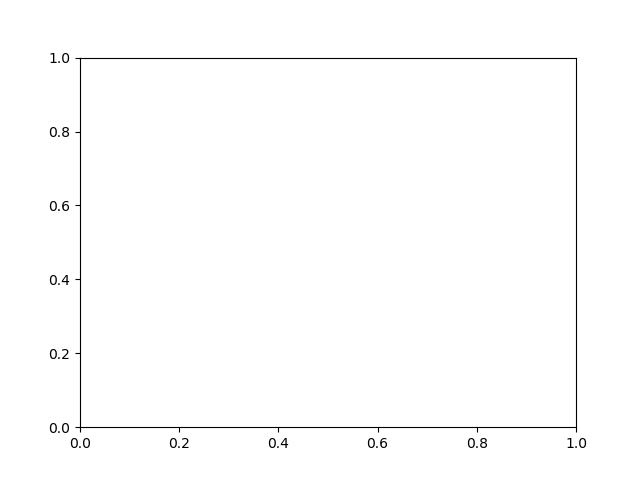

In [6]:
from ipywidgets import IntSlider, FloatText

fig_surface = plt.figure()
ax_time_slider = fig_surface.add_subplot(111)
fig_surface.canvas.set_window_title('Time Slider')

def plot_time_slider(change):
    date = change['new']
    ax_time_slider.cla()
    ax_time_slider.plot(dist_space, density_values[date], color='k', label=exposure_selector.value)
    ax_time_slider.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax_time_slider.set_xlim(npv_min, npv_max)
    ax_time_slider.set_ylim(0, density_max)
    ax_time_slider.set_xlabel("Exposure")
    year_text.value = "{:,.3f}".format(years[date])
    
time_slider = IntSlider(min=0, max=num_dates-1, value=0, description='DateIndex:')
time_slider.observe(plot_time_slider, names='value')
year_text = FloatText(description="Years:", value=years[time_slider.value])
display(HBox([time_slider, year_text]))

## Exposure Statistics (matplotlib)

This plot produces the classical exposure statistics:
* EE = Expected Exposure
* EPE = Expected Positive Exposure
* ENE = Expected Negative Exposure
* PFE = Potential Future Exposure (at a certain quantile)

In [7]:
df_stats = df[(df.NettingSet == netting_set_selector.value) & df.Id.isin(trades_selector.value)][['Id', 'Value', 'Sample', 'DateIndex']].groupby(['DateIndex','Sample']).sum().reset_index()
df_epe = df_stats.copy()
df_ene = df_stats.copy()

df_epe.loc[df_epe['Value']<0,'Value']=0
df_ene.loc[df_ene['Value']>0,'Value']=0

ee = df_stats[['DateIndex', 'Value']].groupby('DateIndex').mean().values[:,0]
epe = df_epe[['DateIndex', 'Value']].groupby('DateIndex').mean().values[:,0]
ene = df_ene[['DateIndex', 'Value']].groupby('DateIndex').mean().values[:,0]

<IPython.core.display.Javascript object>


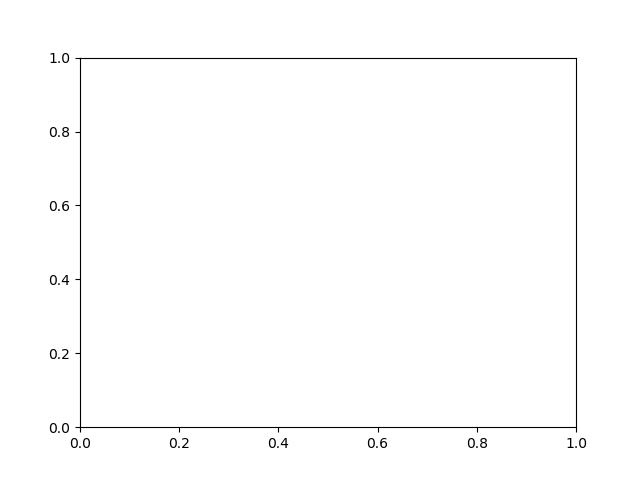

FloatSlider(value=95.0, description='PFE Percentile:', min=90.0)

In [8]:
fig_statistics = plt.figure()
ax_statistics = fig_statistics.add_subplot(111)

dates = pd.to_datetime(df['Date']).unique()
dates = dates - dates.min()
years = dates.astype('timedelta64[D]') / np.timedelta64(1, 'D') / 365
date_step=3

def plot_exposure_statistics(pfe_percentile):
    ax_statistics.cla()
    pfe_percentile_val = pfe_percentile['new']
    ax_statistics.plot(years, ee, label=ExposureTypes.EE.value)
    ax_statistics.plot(years, epe, label=ExposureTypes.EPE.value)
    ax_statistics.plot(years, ene, label=ExposureTypes.ENE.value)
    pfe = df_stats[['DateIndex', 'Value']].groupby('DateIndex').quantile(pfe_percentile_val/100).values[:,0]
    ax_statistics.plot(years, pfe, label='PFE ' + str(pfe_percentile_val))
    ax_statistics.set_xticks(years[::date_step])
    ax_statistics.set_xticklabels(years[::date_step])
    ax_statistics.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: "{:,.1f}".format(x)))
    ax_statistics.set_xlabel('years')

    #ax_statistics.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: "{:,.1f}".format(x)))
    ax_statistics.set_ylabel("Exposure [mn]")
    ax_statistics.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax_statistics.set_ylim([np.amin(df_stats[['DateIndex', 'Value']].groupby('DateIndex').min().values),np.amax(df_stats[['DateIndex', 'Value']].groupby('DateIndex').max().values)*1.01])
    
    fontP = FontProperties() # set legend outside plot
    fontP.set_size('small')
    ax_statistics.legend(loc='upper left', shadow=True, prop=fontP)
    plt.show()
    
percentile_selector = FloatSlider(min=90, max=100, value=95, description='PFE Percentile:')
percentile_selector.observe(plot_exposure_statistics, names='value')
display(percentile_selector)